# Model Comparison continued

##### Keywords: kl-divergence, deviance, AIC, DIC, WAIC, model-comparison, model averaging, in-sample, cross-validation, empirical bayes, LOOCV

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

## Generating a data set

We'll generate a minimal noise data set, from a quadratic model, and we'll then try and fit this model with polynomials of different degrees. The idea is to see what polynomial order is from different model comparison measures.

In [3]:
x = np.random.uniform(size=40)
mu = 15 - 4*x + 3*x**2
sigma=0.2
y = np.random.normal(mu,sigma)

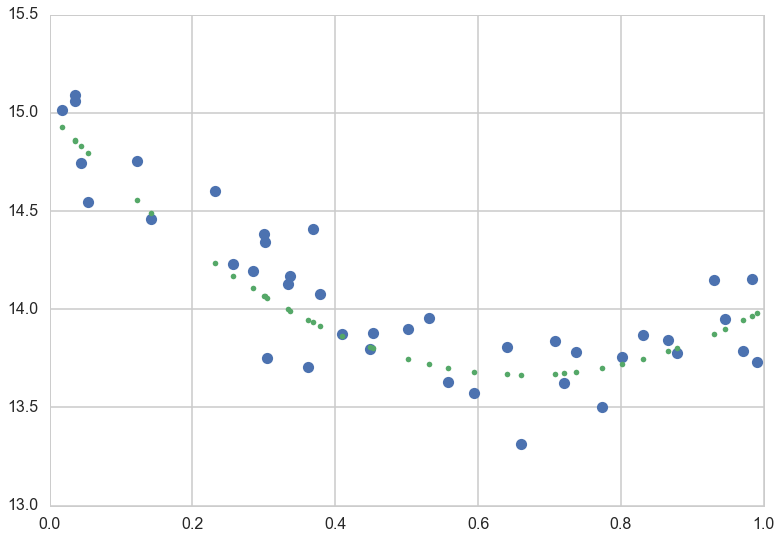

In [4]:
plt.plot(x,y,'o')
plt.plot(x,mu,'.')

### Train-test split

We create a 50-50 train test split. We'd like to keep aside a test set so that we can see how quantities behave on this set.

In [5]:
from sklearn.cross_validation import train_test_split

In [6]:
itrain, itest = train_test_split(range(40), train_size=20)

We'll center the data

In [7]:
x = x - x.mean()

In [8]:
xtrain=x[itrain]
ytrain=y[itrain]
xtest=x[itest]
ytest=y[itest]

In [9]:
ridge = 3

We'll use `scikit-learn` to construct polynomial features:

In [10]:
from sklearn.preprocessing import PolynomialFeatures
import theano.tensor as T

## Simulating an ensemble of models

Now imagine we dont know what generated the data and go to find out:

In [14]:
models20={}

for msize in [1,2, 4, 10, 19]:
    pf=PolynomialFeatures(msize, include_bias=False).fit_transform(xtrain.reshape(-1,1))
    pftest=PolynomialFeatures(msize, include_bias=False).fit_transform(xtest.reshape(-1,1))

    with pm.Model() as m:
        alpha = pm.Normal('alpha', 0, 100)
        beta = pm.Normal('beta', mu=0, sd=ridge, shape=msize)
        mu = alpha + pm.math.dot(pf, beta)
        o = pm.Normal('o', mu, sigma, observed=ytrain)
        trace=pm.sample(5000, init='MAP')
        
    with pm.Model() as mtest:
        alpha = pm.Normal('alpha', 0, 100)
        beta = pm.Normal('beta', mu=0, sd=ridge, shape=msize)
        mu = alpha + pm.math.dot(pftest, beta)
        o = pm.Normal('o', mu, sigma, observed=ytrain)
                           
    models20[msize] = (m, trace, mtest)

Optimization terminated successfully.
         Current function value: 13.018754
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5


100%|██████████| 5000/5000 [00:04<00:00, 1214.50it/s]  | 115/5000 [00:00<00:04, 1149.81it/s]


Optimization terminated successfully.
         Current function value: 2.895004
         Iterations: 3
         Function evaluations: 7
         Gradient evaluations: 7


100%|██████████| 5000/5000 [00:12<00:00, 408.23it/s]   | 12/5000 [00:00<00:41, 119.95it/s]


Optimization terminated successfully.
         Current function value: 6.137226
         Iterations: 11
         Function evaluations: 15
         Gradient evaluations: 15


100%|██████████| 5000/5000 [02:12<00:00, 37.65it/s]    | 4/5000 [00:00<02:17, 36.22it/s]


Optimization terminated successfully.
         Current function value: 18.208503
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 5000/5000 [05:05<00:00, 15.54it/s]    | 4/5000 [00:00<03:45, 22.20it/s]


Optimization terminated successfully.
         Current function value: 36.366457
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20


100%|██████████| 5000/5000 [05:18<00:00, 11.09it/s]    | 4/5000 [00:00<02:24, 34.52it/s]


We have produced an ensemble of 6 models with traces and both training and testing models which we can now use.

In [15]:
models20

{1: (<pymc3.model.Model at 0x125e27ef0>,
  <MultiTrace: 1 chains, 5000 iterations, 2 variables>,
  <pymc3.model.Model at 0x1270019b0>),
 2: (<pymc3.model.Model at 0x127c78ba8>,
  <MultiTrace: 1 chains, 5000 iterations, 2 variables>,
  <pymc3.model.Model at 0x12816dd30>),
 4: (<pymc3.model.Model at 0x128511438>,
  <MultiTrace: 1 chains, 5000 iterations, 2 variables>,
  <pymc3.model.Model at 0x1289ffe10>),
 10: (<pymc3.model.Model at 0x128c73a58>,
  <MultiTrace: 1 chains, 5000 iterations, 2 variables>,
  <pymc3.model.Model at 0x1296dc0f0>),
 19: (<pymc3.model.Model at 0x128b8e048>,
  <MultiTrace: 1 chains, 5000 iterations, 2 variables>,
  <pymc3.model.Model at 0x129f9f518>)}

## Information Criteria

All information criteria derive from the **Deviance**, which we learnt about when we learned about the KL-divergence. Here is a short summary.

If $p$ is nature's distribution, we want to know how far we are from "perfect accuracy" by using $q$. In other words we need to develop a distance scale for distances between distributions.

This scale is called the Kullback-Leibler (KL) Divergence, introduced in 1951. It is defined thus:

$$\renewcommand{\kld}{D_{KL}}$$

$$\kld(p, q) = E_p[log(p) - log(q)] = E_p[log(p/q)] = \sum_i p_i log(\frac{p_i}{q_i}) \,\,or\, \int dP log(\frac{p}{q})$$

The distance between a distribution and itself is clearly $\kld(p,p) = 0$.

We can use Jensen's inequality for expectations on a convex function $f(x)$,

$$ E[f(X)] \ge f(E[X]) $$

to show that $\kld(p,q) \ge 0$ with equality iff (if and only if) $q=p$.

If one uses the **law or large numbers** to replace the true distribution by its empirical estimate, then we have:

$$\kld(p, q) = E_p[log(p/q)] = \frac{1}{N}\sum_i (log(p_i) - log(q_i)$$

Thus minimizing the KL-divergence involves maximizing $\sum_i log(q_i)$ which is exactly the log likelihood. Hence we can justify the maximum likelihood principle.

### Comparing models

By the same token we can use the KL-Divergences of two different models to do model comparison:

$$\kld(p, q) -\kld(p, r) = E_p[log(r) - log(q)] = E_p[log(\frac{r}{q})]$$

Notice that except for choosing the empirical samples, $p$ has dissapeared from this formula.

f you look at the expression above, you notice that to compare a model with distribution $r$ to one with distribution $q$, you only need the sample averages of the logarithm of $r$ and $q$:

$$\kld(p, q) -\kld(p, r) = \langle log(r) \rangle - \langle log(q) \rangle$$

where the angled brackets mean sample average. If we define the deviance:

$$D(q) = -2 \sum_i log(q_i)$$,

then

$$\kld(p, q) -\kld(p, r) = \frac{2}{N} (D(q) - D(r))$$

so that we can use the deviance's for model comparison instead.

More generally, we can define the deviance without using the sample average over the empirical distribution as

$$ D(q) = - \frac{N}{2} E_p[log(q)] $$

Now in the frequentist realm one used likelihoods. In the bayesian realm, the **posterior predictive**, which has learned from the data seems to be the more sensible distribution to use. But lets work our way there.

In other words, we are trying to estimate $E_p[log(pp(y))]$ where $pp(y)$ is the posterior predictive for points $y$ on the test set or future data.

We replace this joint posterior predictive over new points $y$ by product of marginals and thus a sum of log-marginals at new points(since we are doing logs). 

$$\sum_i E_p[log(pp(y_i))]$$

The quantity inside the sum is called the elpd (expected log predictive density) and the entire thing the elppd (expected log pointwise predictive density. Clearly the product of marginals is not the joint, so this is a different quantity, crafted to give us a pointwise notion of deviance.

## The WAIC

This is finally, a fully bayesian construct.

It does not require a multivariate gaussian posterior. The distinguishing feature of it is that its pointwise, it does not use the joint $p(y)$ to make its estimates. This is very useful for glms by fitting for each observation, then summing up over observations.

Since we do not know the true distribution $p$, we replace the Deviance term 

$$\sum_i E_p[log(pp(y_i))]$$

where $y_i$ are new
 
by the computed "log pointwise predictive density" (lppd) **in-sample**

$$\sum_j log\left<p(y_j \vert \theta)\right> = \sum_j log\left(\frac{1}{S}\sum_s p(y_j \vert \theta_s) \right)$$

which now does the full monte-carlo average in the angled brackets on a point-wise basis.

The lppd is the total across in-sample observations of the average likelihood (over the posterior of each observation. Multiplied by -2, its the pointwise analog of deviance.

The $p_W$ correction also becomes more fully bayesian, as in being

$$p_W = 2\sum_i \left(log(E_{post}[p(y_i \vert \theta)] - E_{post}[log(p(y_i \vert \theta))] \right)$$

Once again this can be estimated by
$$\sum_i Var_{post}[log(p(y_i \vert \theta))]$$

If you do these calculations by hand (and you should to check) make sure you use the `log-sum-exp` trick. Start with log(p), exponential it, sum it, and log again.

Now

$$WAIC = lppd +2 p_W$$

In [16]:
for npa in models20:
    m,t, test=models20[npa]
    print("For Model with {} slope, waic is {}".format(npa, pm.waic(t, model=m)))

//anaconda/envs/py35/lib/python3.5/site-packages/pymc3/stats.py:145: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


For Model with 1 slope, waic is WAIC_r(WAIC=18.086154924759676, WAIC_se=10.162063571524614, p_WAIC=4.6685686490640128)
For Model with 2 slope, waic is WAIC_r(WAIC=-7.9746057666052668, WAIC_se=4.8913389425902176, p_WAIC=2.8290346198804275)
For Model with 19 slope, waic is WAIC_r(WAIC=61.178349788662352, WAIC_se=25.002444963302214, p_WAIC=38.140875766495071)
For Model with 4 slope, waic is WAIC_r(WAIC=-5.1476015964310298, WAIC_se=4.5248859948089732, p_WAIC=5.0163702157862842)
For Model with 10 slope, waic is WAIC_r(WAIC=91.825697802482608, WAIC_se=34.336737894534828, p_WAIC=53.519631187786722)


As we saw earlier in machine learning, many polynomial models will be fine. We next see an example of model-selection in Posson regression which puts the WAIC to good use.

## Using information criteria

I will just quote McElreath:

>But once we have DIC or WAIC calculated for each plausible model, how do we use these values? Since information criteria values provide advice about relative model performance, they can be used in many different ways. Frequently, people discuss MODEL SELECTION, which usually means choosing the model with the lowest AIC/DIC/WAIC value and then discarding the others. But this kind of selection procedure discards the information about relative model accuracy contained in the differences among the AIC/DIC/WAIC values. Why is this information useful? Because sometimes the differences are large and sometimes they are small. Just as relative posterior probability provides advice about how confident we might be about parameters (conditional on the model), relative model accuracy provides advice about how confident we might be about models (conditional on the set of models compared).

>So instead of model selection, this section provides a brief example of model comparison and model averaging.
- MODEL COMPARISON means using DIC/WAIC in combination with the estimates and posterior predictive checks from each model. It is just as important to understand why a model outperforms another as it is to measure the performance difference. DIC/WAIC alone says very little about such details. But in combination with other information, DIC/WAIC is a big help.
- MODEL AVERAGING means using DIC/WAIC to construct a posterior predictive distribution that exploits what we know about relative accuracy of the models. This helps guard against overconfidence in model structure, in the same way that using the entire posterior distribution helps guard against overconfidence in parameter values. What model averaging does not mean is averaging parameter estimates, because parameters in different models have different meanings and should not be averaged, unless you are sure you are in a special case in which it is safe to do so. So it is better to think of model averaging as prediction averaging, because that's what is actually being done. (McElreath 195-196)



**It is critical that you use information criteria to only compare models with the same likelihood**. 

Let me quote McElreath again:

>it is tempting to use information criteria to compare models with different likelihood functions. Is a Gaussian or binomial better? Can't we just let WAIC sort it out?

>Unfortunately, WAIC (or any other information criterion) cannot sort it out. The problem is that deviance is part normalizing constant. The constant affects the absolute magnitude of the deviance, but it doesn't affect fit to data. Since information criteria are all based on deviance, their magnitude also depends upon these constants. That is fine, as long as all of the models you compare use the same outcome distribution type—Gaussian, binomial, exponential, gamma, Poisson, or another. In that case, the constants subtract out when you compare models by their differences. But if two models have different outcome distributions, the constants don't subtract out, and you can be misled by a difference in AIC/DIC/WAIC. (McElreath 288)


## Cross-Validation

k-fold cross validation is a technique we have learned about earlier (much earlier in the course) to split the training set into a training and validation in such a way that we can estimate the out-of-sample risk as an average, thus gaining robustness to odd validation sets, and also providing some measure of uncertainty on the out-of-sample performance.

Note that cross-validation is a direct measure of out-of-sample performance, as opposed to the information criteria which fit a model on the whole set and have to then deal with a penalty or bias term that comes from estimating out of sample performance on the training set.

If you do cross-validation with 5-10 folds, your computational burden may not be excessively higher, and now you can compare models with different likelihoods, unlike with information criteria.

However, you do pay the piper. Because you have less data for your fit, you may not choose as expressive a model, and might need stronger priors to provide more regularization if you decide to continue with a very expressive model.

Notice that we are not talking here about cross-validation to do hyperparameter optimization, but rather to compute out of sample utility or risk. In the bayesian scenario, the hyperparameters are part of the prior specification, and might have been chosen a-priori or are learnt from the data in hierarchical model style.

### Cross Validation vs Empirical Bayes

Type-2 Maximum Likelihood, or empirical bayes is an alternative to cross-validation, which allows us to use the entire data set rather than having to deal with cross-validation folds. Remember that there we marginalize over the parameters, essentially calculating a posterior predictive that is also a function of the hyperparameters. We then optimize this function with respect to the hyperparameters to provide values for the hyperparameters. 

But this is not a model-selection procedure. It can be used to create the model which may then be compared using information criteria or regular cross-validation.

EB has its own problems, primarily having to do with model mis-specification. This is actively being researched, see http://stats.stackexchange.com/questions/24799/cross-validation-vs-empirical-bayes-for-estimating-hyperparameters for some discussion.

## LOOCV

A particular kind of cross-validation is LOOCV, or leave-one-out cross-validation. The idea here is that you fit a model on N-1 data points, and use the Nth point as a validation point. Clearly this can be done in N ways.

LOOCV has all kinds of nice properties, including analytic estimates for some models. Additionally, unless the left out point is outlierish or very unusual, the N-point and N-1 point posteriors are likely to be quite similar, and one can sample one from the other by using importance sampling.

In importance sampling remember that you typically want to calculate something like $E_f[h]$. This can be written as $E_g[h*\frac{f}{g}]$. When we go over to the samples then we can write:

$$E_f[h] = \frac{\sum_s w_s h_s}{\sum_s w_s}$$

where $w_s = f_s/g_s$.

What we want to do is to fit the full model once. Then we have

$$w_s = \frac{p(\theta_s \vert y_{-i})}{p(\theta_s \vert y)} \propto \frac{1}{p(y_i \vert \theta_s, y_{-i})}$$

Unfortunately the importance sampling weights can be unstable out in the tails. This is as the full-N posteriors tend to have smaller variances and are thus thinner tailed as compared to the leave-one-out distributions, leading to large variances in importance sampling weights. For simple models these weights can be computed analytically, but for others, following https://arxiv.org/abs/1507.04544, pymc implements pareto smoothed importance sampling to compare models.

Since the importance weights have a long right tail, one fits a generalized pareto to the tail (largest 20% importance ratios) for each held out data point i (a MLE fit). This smooths out any large variations. The entire process is a bit complex and described in the paper above.

We simply calculate the loocv estimates of the out-of-sample predictive fit elpd (remember there is an expectation value inside the log) is:

$$elpd_{loo} = \sum_i log(p(y_i \vert y_{-i}))$$

$$ = \sum_i log\left(\frac{\sum_s w_{is} p(y_i \vert \theta_s)}{\sum_s w_{is}}\right)$$

over the training sample

In [17]:
for npa in models20:
    m,t, test=models20[npa]
    print("For Model with {} slope, loo is {}".format(npa, pm.loo(t, model=m)))

//anaconda/envs/py35/lib/python3.5/site-packages/pymc3/stats.py:208: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is
        because importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


For Model with 1 slope, loo is LOO_r(LOO=19.345559544708721, LOO_se=10.448387931742174, p_LOO=5.2982709590385335)
For Model with 2 slope, loo is LOO_r(LOO=-6.4907292356212007, LOO_se=5.6639101289730434, p_LOO=3.5709728853724583)
For Model with 19 slope, loo is LOO_r(LOO=1.1788924202325761, LOO_se=7.3342281925207269, p_LOO=8.1411470822801828)
For Model with 4 slope, loo is LOO_r(LOO=-7.8411331189326319, LOO_se=4.9343760037143145, p_LOO=3.6696044545354827)
For Model with 10 slope, loo is LOO_r(LOO=-1.3783161338355767, LOO_se=6.6512996064759902, p_LOO=6.917624219627621)


## What should you use?

These are practical tips collated from McElreath, http://andrewgelman.com/2014/05/26/waic-cross-validation-stan/, and https://arxiv.org/abs/1507.04544

1. LOOCV and WAIC are fine. The former can be used for models not having the same likelihood, the latter can be used with models having the same likelihood. 
2. WAIC is fast and computationally less intensive, so for same-likelihood models (especially nested models where you are really performing feature selection), it is the first line of attack
3. One does not always have to do model selection. Sometimes just do posterior predictive checks to see how the predictions are, and you might deem it fine.
4. For hierarchical models, WAIC is best for predictive performance within an existing cluster or group. Cross validation is best for new observations from new groups

